# 1. 로지스틱 회귀 

## 문제 : 럭키백에 임의의 생선이 1개 들어감 
- 럭키백 속에 들어가는 생성의 확률 구하기
- 길이 , 높이, 두께, 대각선, 무게 사용 가능 

# 2. 데이터 준비 


In [66]:
import pandas as pd 
fish = pd.read_csv("https://bit.ly/fish_csv_data")
fish.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


## 1) 데이터 확인  및 input 데이터 만들기 

In [67]:
### 종 정보  
print(pd.unique(fish["Species"]))

['Bream' 'Roach' 'Whitefish' 'Parkki' 'Perch' 'Pike' 'Smelt']


- 종을 제외한 데이터를 input 데이터로 만듦 

In [68]:
fish_input = fish[["Weight", "Length","Diagonal","Height","Width"]]
fish_input.head()

,Weight,Length,Diagonal,Height,Width
0,242.0,25.4,30.0,11.5200,4.0200
1,290.0,26.3,31.2,12.4800,4.3056
2,340.0,26.5,31.1,12.3778,4.6961
3,363.0,29.0,33.5,12.7300,4.4555
4,430.0,29.0,34.0,12.4440,5.1340


In [69]:
### 정답 데이터 만들기 
fish_target = fish["Species"]
fish_target.head()

0    Bream
1    Bream
2    Bream
3    Bream
4    Bream
Name: Species, dtype: object

## 2) 훈련/테스트 세트 나누기 

In [70]:
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

## 3) 데이터 표준화 전처리 

In [71]:
from sklearn.preprocessing import StandardScaler
ss =StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

## 4) K 최근접 이웃 분류기의 한계 

- 다중 분류 :  2개 이상의 클래스가 포함된 문제  

In [72]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier(n_neighbors=3)
kn.fit(train_scaled,train_target)
print(f"모델 평가 (훈련) : {kn.score(train_scaled,train_target)}")
print(f"모델 평가 (검증) : {kn.score(test_scaled,test_target)}")

모델 평가 (훈련) : 0.8907563025210085
모델 평가 (검증) : 0.85


- 예측 값 테스트 
  - `predict_prob` 에는 어떤 확률로 해당 클래스를 리턴했는지 알 수 있음 
  - [[0. 0. 1. 0. 0. 0. 0.] = ['Perch' 'Perch' 'Smelt' 'Bream' 'Pike'] 일 확률

In [73]:
import numpy as np

print("예측 클래스")
print(kn.predict(test_scaled[:5]))
proba = kn.predict_proba(test_scaled[:5])
print("예측 확률")
print(np.round(proba,decimals=4))

예측 클래스
['Perch' 'Smelt' 'Pike' 'Perch' 'Perch']
예측 확률
[[0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]
 [0.     0.     0.6667 0.     0.3333 0.     0.    ]]


- k 최근접 모델이 가장 가까운 이웃의 비율과 맞는 지 확인   
  - 이웃이 3개이기 때문에 가능한 확률은 0, 1/3,2/3,1 뿐임 
  - 부적절함 

In [74]:
distance, indexs = kn.kneighbors(test_scaled[3:4])
print(train_target.iloc[indexs[0]])

52     Roach
106    Perch
103    Perch
Name: Species, dtype: object


# 3. 로지스틱 회귀 (Logistic Regression)
## 1) 정의 
 - 분류 모델 
- 선형 방정식을 학습
- 각 피쳐에 대한 가중치(계수)를 부여 
- 식 : $z = a \cdot (Weight) + b \cdot (Legnth) +  c \cdot (Diagonal) +  d \cdot (Height) + e \cdot (Width) + f $
- $z$ 값은 어떤 값이든 될 수 있음 
  - 하지만 **확률** 이 나와야함 (0~1 사이 값이 필요)
  - 시그모이드 함수를 이용해서 숫자를 조정함 

## 2) 시그모이드 함수 
- **시그모이드 함수** : $\sigma(x) = \frac{1}{1 + e^{-x}}$
  - 지수 함수의 미분 함수 
  - y 값의 범위가 0~1 사이 
    - 0.5 보다 작음 > `음성 클래스`
    - 0.5 보다 큼 > `양성 클래스` 

 ## 3) 시그모이드 함수 구현
 넘파이의 `np.exp()` 를 이용해 자연상수를 표현 

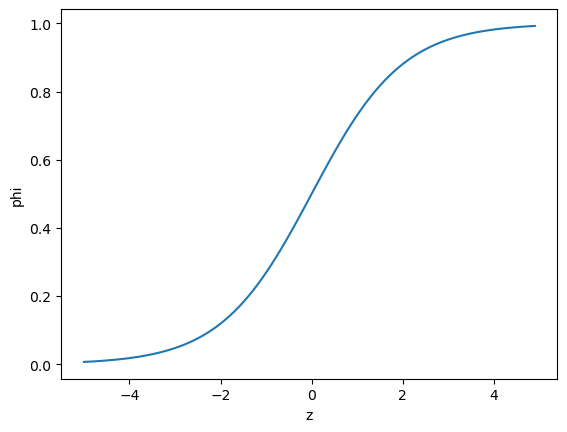

In [75]:
### 시그모이드 함수를 구현 + 시각화 
### z 값은 범위는 -5 ~ 5  // 간격은 0.1

import numpy as np 
import matplotlib .pyplot as plt 

### 범위 설정 
z = np.arange(-5,5,0.1)

### 시그모이드 구현 1 / 1 + exp^-z 
phi = 1 / (1 + np.exp(-z))

### 시각화 
plt.plot(z, phi)
plt.xlabel("z")
plt.ylabel("phi")
plt.show()


## 4) 로지스틱 회귀로 이진 분류 수행 
- `불리언 인덱싱` : 불리언 값을 전달해서 행을 전달 가능 
    - [1 , 2, 3, 4] <- [Ture, False, False,Ture] 하면 [1,4] 만 나옴 
  - 이를 이용해 도미와 빙어만 출력  

In [76]:
bream_smelt_indexes = (train_target == "Bream") | (train_target == "Smelt") 

### 기존 데이터에서 도미와 빙어 데이터만 가져옴 
train_bream_smelt = train_scaled[bream_smelt_indexes]
target_bream_smelt = train_target[bream_smelt_indexes]

In [77]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

### 모델 학습 
lr.fit(train_bream_smelt,target_bream_smelt)

### 샘플 5개 테스트 
print("샘플 예측 : ", lr.predict(train_bream_smelt[:5]))
print("확률 확인 :")
print(lr.predict_proba(train_bream_smelt[:5]))

### 양성클래스는 ? 
print(f"음성 클래스 : {lr.classes_[0]} , 양성 클래스 : {lr.classes_[1]}")

###  계수 확인 
print("가중치(계수) 확인 : " , lr.coef_,lr.intercept_)

샘플 예측 :  ['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']
확률 확인 :
[[0.99760007 0.00239993]
 [0.02737325 0.97262675]
 [0.99486386 0.00513614]
 [0.98585047 0.01414953]
 [0.99767419 0.00232581]]
음성 클래스 : Bream , 양성 클래스 : Smelt
가중치(계수) 확인 :  [[-0.40451732 -0.57582787 -0.66248158 -1.01329614 -0.73123131]] [-2.16172774]


- 학습한 방정식 : 
- $ z= -0.42\cdot (weight) -0.57 \cdot (legth) -0.66 /cdot (diagonal) - 1.01 \cdot (height) - 0.78 \cdot (width) -2.28 $
- `decision_function` : 값에 대한 z 값 출력 
- `expit()` : 시그모이드 함수를 통과 - np.exp() 보다 나음 

- 시그모이드를 적용한 값은 `r.predict_proba(train_bream_smelt[:5])` 의 2열과 동일한 값을 가짐

In [78]:
decision = lr.decision_function(train_bream_smelt[:5])
print("z 값 : ",decision)

from scipy.special import expit
print("시그모이드를 적용한 z 값 : " , expit(decision))


z 값 :  [-6.02991358  3.57043428 -5.26630496 -4.24382314 -6.06135688]
시그모이드를 적용한 z 값 :  [0.00239993 0.97262675 0.00513614 0.01414953 0.00232581]


## 5) 로지스틱 회귀로 다중 분류
- 7개의 생선 분류 
- LogisticRegression 는 반복적인 알고리즘을 사용
  - 기본 반복값 : `max_iter` 는 100 

- 규제 추가 
  - 로지스틱의 규제 : `L2` 규제 
  - 규제를 제어하는 매개변수 `C`
- 작을 수록 규제가 커짐 
- 기본값 1 
- 계수의 제곱값을 규제함 

In [82]:
lr = LogisticRegression(C=20, max_iter=1000)

### 모델 학습 
lr.fit(train_scaled,train_target)

### 모델 평가 
print("모델 평가 (훈련) : ",lr.score(train_scaled,train_target))
print("모델 평가 (검증) : ",lr.score(test_scaled,test_target))

### 샘플 5개에 대한 예측 
print(lr.predict(test_scaled[:5]))
proba = lr.predict_proba(test_scaled[:5])
print(np.round(proba,decimals=2))

### 클래스 확인 
print("클래스 : " , lr.classes_)

모델 평가 (훈련) :  0.9327731092436975
모델 평가 (검증) :  0.925
['Perch' 'Smelt' 'Pike' 'Roach' 'Perch']
[[0.   0.01 0.84 0.   0.13 0.01 0.  ]
 [0.   0.   0.04 0.   0.01 0.95 0.  ]
 [0.   0.   0.03 0.93 0.02 0.02 0.  ]
 [0.01 0.03 0.31 0.01 0.57 0.   0.08]
 [0.   0.   0.9  0.   0.09 0.   0.  ]]
클래스 :  ['Bream' 'Parkki' 'Perch' 'Pike' 'Roach' 'Smelt' 'Whitefish']


## 6) 소프트맥스 함수 

In [80]:
### 계수 / 절편 확인 
print(lr.coef_.shape, lr.intercept_.shape)

(7, 5) (7,)


- 7행 > 총 7개의 z 값을 계산 
- 높은 z값이 나오는 것이 예측 클래스가 됨 
- 확률은 `소프트맥스` 함수를 이용 

- 소프트 맥수 함수 : 
  - 여러 개의 선형 방정식의 출력값을 0~1 사이 값으로 압축
  - 전체 합이 1이 되도록 만듦
  - 정규화된 지수함수 
  - 구현 : `softmax()`

In [ ]:
### 소프트 맥스 함수를 이용하여 확률 확인
decision = lr.decision_function(test_scaled[:5])
print(np.round(decision,decimals=2))


### 소프트 맥스 함수로 확인  > 앞서구한 proba와 동일 
from scipy.special import softmax
proba = softmax(decision, axis=1)
print(np.round(proba, decimals=2))

[[ -6.51   1.04   5.17  -2.76   3.34   0.35  -0.63]
 [-10.88   1.94   4.78  -2.42   2.99   7.84  -4.25]
 [ -4.34  -6.24   3.17   6.48   2.36   2.43  -3.87]
 [ -0.69   0.45   2.64  -1.21   3.26  -5.7    1.26]
 [ -6.4   -1.99   5.82  -0.13   3.5   -0.09  -0.7 ]]
[[0.   0.01 0.84 0.   0.13 0.01 0.  ]
 [0.   0.   0.04 0.   0.01 0.95 0.  ]
 [0.   0.   0.03 0.93 0.02 0.02 0.  ]
 [0.01 0.03 0.31 0.01 0.57 0.   0.08]
 [0.   0.   0.9  0.   0.09 0.   0.  ]]
